## **Objetivo:**

Ajustadas las proyecciones de los estados hacer lo siguiente:
- Graficar evolución de los estados: Perdida del beneficio, Sin bolsa de créditos, Abandono
- Zoom en la trayectoria histórica de a) sin bolsa de créditos b) pérdida del beneficio.
- Eliminar duplicados y mostrar el # de observaciones imputadas para el estado *matriculado*

- ¿Cómo? Utilizando la **data panel** que guarda la información histórica de la maestra.

**Insumos**
- Tenemos el panel histórico de estudiantes: *panel_estudiantes_v2509.pkl*
- Tenemos las proyecciones de cada estudiante: *proyecciones_todos_niveles_a_partir_20252.xlsx*

**Observaciones**
- Para la proyección se imputaron los estados sin valor a matriculados.
- **Importante**: El panel historico debe ser el mismo que se utilizó para generar las proyecciones

## **Secciones de este notebook**

1. Graficar histórico
2. Graficar proyecciones
3. Graficar panorama completo 

----

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re

from matplotlib.figure import Figure
from typing  import Optional, Tuple, List

----

In [2]:
from datetime import datetime
fecha_hoy = datetime.today().strftime("%Y%m%d")

In [3]:
PANEL_PATH = "../../../03_Modeling/Classification_Task/99_Data/Raw_Panel/"
panel_file = "panel_estudiantes_V12_BDM20251015.pkl"

version_panel = re.search(r'V\d{2}', panel_file).group(0)
print(f"Version Panel: {version_panel}")

Version Panel: V12


## **Sección 1: Graficar histórico**

**Datos**

In [4]:
#dataframe con el histórico de trayectorias
df = pd.read_pickle(PANEL_PATH + panel_file)

In [5]:
print("Numero de observaciones por individuo")
display(df.groupby("DOCUMENTO").count().head().periodo_orden)
convocatoria_ejemplo = df.query("DOCUMENTO == 774948").CONVOCATORIA
print(f"Convocatoria ejemplo {774948}")

Numero de observaciones por individuo


DOCUMENTO
478541    6
511289    8
517792    4
707194    2
774948    1
Name: periodo_orden, dtype: int64

Convocatoria ejemplo 774948


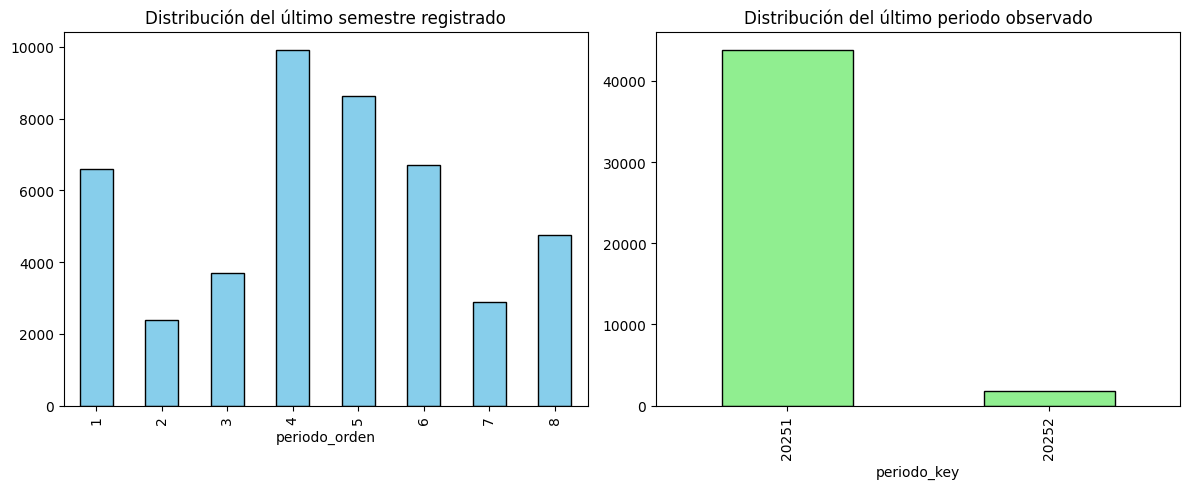

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

(
    df.sort_values(["DOCUMENTO", "periodo_orden"])
      .drop_duplicates("DOCUMENTO", keep="last")["periodo_orden"]
      .value_counts()
      .sort_index()
      .plot(
          kind="bar",
          ax=axes[0],
          color="skyblue",
          edgecolor="black",
          title="Distribución del último semestre registrado"
      )
)

(
    df.sort_values(["DOCUMENTO", "periodo_key"])
      .drop_duplicates("DOCUMENTO", keep="last")["periodo_key"]
      .value_counts()
      .sort_index()
      .plot(
          kind="bar",
          ax=axes[1],
          color="lightgreen",
          edgecolor="black",
          title="Distribución del último periodo observado"
      )
)

plt.tight_layout()
plt.show()


In [7]:
df.query("N_Graduado==1").count()[:1]

DOCUMENTO    1266
dtype: int64

**Tabla con los nombres de los estados**

In [8]:
# Paleta sobria con Graduado en verde BCG
state_colors = {
    "Matriculado": "#0072B2",             # Azul llamativo
    "Aplazado": "#c49c48",                # Beige dorado
    "Abandono": "#8b0000",                # Rojo vino
    "Graduado": "#0A6F37",                # Verde BCG
    "Pérdida del Beneficio": "#6b5b95",   # Púrpura sobrio
    "Sin bolsa de creditos": "#000000",
    "No aplica": "#C9C0B9"   # Gris acero
}

listado_estados = pd.DataFrame(df.estado.unique(), columns = ["Estados"])

estados_absorbentes = ["Graduado", "Abandono", "Sin bolsa de creditos", "Pérdida del Beneficio"]
listado_estados['es_absorbente'] = listado_estados['Estados'].apply(lambda x: 1 if x in estados_absorbentes else 0)
listado_estados["color"] = listado_estados["Estados"].apply(lambda x: state_colors.get(x, "#000000"))

listado_estados

,Estados,es_absorbente,color
0,Matriculado,0,#0072B2
1,Graduado,1,#0A6F37
2,Aplazado,0,#c49c48
3,Abandono,1,#8b0000
4,Pérdida del Beneficio,1,#6b5b95
5,Sin bolsa de creditos,1,#000000


**Funciones**

In [9]:
def detectar_primer_ocurrencia_estado(
    data: pd.DataFrame,
    estado: str
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Detecta y recorta las trayectorias individuales hasta la primera ocurrencia de un estado específico,
    eliminando las observaciones posteriores para cada individuo. 

    Adicionalmente, genera una tabla resumen con el conteo y porcentaje de ocurrencias del estado
    por periodo, permitiendo visualizar la evolución temporal de dicho evento.

    Parameters
    ----------
    data : pandas.DataFrame
        DataFrame original que contiene las trayectorias de los individuos. 
        Debe incluir al menos las siguientes columnas:
        - `"DOCUMENTO"`: identificador único de cada individuo.
        - `"periodo_orden"`: periodo o unidad temporal ordenable.
        - `estado`: columna de conteos que indica la cantidad de veces que se ha presentado el estado. 
    estado : str
        Nombre de la columna en `data` que representa el estado a detectar (por ejemplo `"N_Abandono"`, `"N_Graduado"`, etc.).

    Returns
    -------
    tuple of pandas.DataFrame
        - **df_filtrado** (`pandas.DataFrame`): subconjunto del DataFrame original donde cada individuo
          aparece solo hasta su primera ocurrencia del estado.
        - **tabla_pct** (`pandas.DataFrame`): tabla con los porcentajes de ocurrencia del estado por periodo.

    Notes
    -----
    - La función asume que la columna `estado` contiene valores binarios (0 o 1).
    - Si un individuo nunca presenta el estado (valor `1`), se conserva toda su trayectoria.
    - El DataFrame se ordena internamente por `DOCUMENTO` y `periodo_orden` antes del procesamiento.
    - La tabla porcentual (`tabla_pct`) puede usarse directamente para visualizaciones apiladas
      o análisis de evolución temporal.

    Example
    -------
    >>> df_filtrado, tabla_pct = detectar_primer_ocurrencia_estado(
    ...     data=df_panel,
    ...     estado="Abandono"
    ... )
    >>> df_filtrado.head()
    >>> tabla_pct.tail()
    """
    
    # Ordenar el dataframe
    data = data.sort_values(["DOCUMENTO", "periodo_orden"])
    
    # Detectar la primera ocurrencia de estado
    primera_ocurrencia = (
        data[data[estado] == 1]
        .groupby("DOCUMENTO")["periodo_orden"]
        .min()
    )
    
    # Recortar trayectorias hasta la primera ocurrencia de estado
    df_filtrado_aux = []
    for doc, group in data.groupby("DOCUMENTO"):
        if doc in primera_ocurrencia:  
            cutoff = primera_ocurrencia.loc[doc]
            group = group[group["periodo_orden"] <= cutoff]
        df_filtrado_aux.append(group)
    
    df_filtrado_aux = pd.concat(df_filtrado_aux, axis=0)
    
    # Conteos
    tabla = (
        df_filtrado_aux
        .groupby("periodo_orden")[estado]
        .value_counts()
        .unstack(fill_value=0)
    )
    
    # Proporciones (%)
    tabla_pct = tabla.div(tabla.sum(axis=1), axis=0) * 100

    return df_filtrado_aux, tabla_pct
        

In [10]:
def plot_evolucion_estado(
    df: pd.DataFrame,
    estado: str,
    titulo: Optional[str] = None,
    subtitulo: Optional[str] = None,
    figsize: Tuple[int, int] = (16, 12),
    umbral: int = 2,
    mostrar_tabla: bool = True,
    output_file: str = None,
    ax: plt.Axes = None  
) -> Figure:
    """
    Genera un gráfico de evolución del estado por periodo, con tabla opcional.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame con columnas 'periodo_orden' y el estado analizado.
    estado : str
        Columna binaria a analizar (ej. "N_Abandono").
    titulo : str, optional
        Título del gráfico.
    subtitulo : str, optional
        Subtítulo debajo del gráfico.
    figsize : tuple of int, optional
        Tamaño de figura.
    umbral : int, optional
        Mínimo porcentaje para mostrar etiquetas.
    mostrar_tabla : bool, optional
        Si True, muestra la tabla de totales debajo del gráfico.
    output_file : str, optional
        Ruta para guardar el gráfico.
    ax : matplotlib.axes.Axes, optional
        Eje existente donde dibujar el gráfico (para usar dentro de grillas de subplots).

    Returns
    -------
    matplotlib.figure.Figure
        Figura generada (o figura del subplot si se usó `ax`).
    """

    # --- 📊 Agrupación y conteo ---
    counts = (
        df
        .groupby("periodo_orden")[estado]
        .value_counts()
        .unstack(fill_value=0)
    )

    # --- 🔧 Asegurar que existan ambas columnas (0 y 1) ---
    posibles_valores = counts.columns.tolist()
    if len(posibles_valores) == 1:
        unico = posibles_valores[0]
        faltante = 1 if unico == 0 else 0
        counts[faltante] = 0
    counts = counts[[0, 1]]
    counts.columns = [f"No {estado}", estado]

    # Totales
    counts["Total"] = counts.sum(axis=1)
    totals_row = counts.sum(axis=0).to_frame().T
    totals_row.index = ["Total"]
    counts = pd.concat([counts, totals_row])

    # % para gráfica
    percentages = counts.drop(index="Total").iloc[:, :-1]
    percentages = percentages.div(percentages.sum(axis=1), axis=0) * 100

    # --- 🎨 Crear figura ---
    if ax is None:
        if mostrar_tabla:
            fig, (ax_plot, ax_table) = plt.subplots(
                2, 1, figsize=figsize,
                gridspec_kw={"height_ratios": [3, 1]}
            )
        else:
            fig, ax_plot = plt.subplots(figsize=figsize)
            ax_table = None
    else:
        fig = ax.figure
        ax_plot = ax
        ax_table = None

    fig.patch.set_facecolor("#2E2E2E")
    ax_plot.set_facecolor("#2E2E2E")

    # 🎨 Colores ejecutivos
    palette = ["#1f77b4", "#7f7f7f"]

    # Gráfico
    percentages.plot(
        kind="bar",
        stacked=True,
        ax=ax_plot,
        color=palette,
        edgecolor="none"
    )

    # Título
    total_general = counts.loc["Total", "Total"]
    ax_plot.set_title(
        titulo or f"Distribución de {estado} por periodo",
        fontsize=16, fontweight="bold", color="white", pad=20
    )

    if subtitulo and ax is None:  # evitar superposición en subplots
        plt.figtext(0.5, -0.02, subtitulo, ha="center", fontsize=11, color="#C0C0C0")

    ax_plot.set_xlabel("Periodo", fontsize=12, color="white")
    ax_plot.set_ylabel("% estudiantes", fontsize=12, color="white")
    ax_plot.tick_params(axis="x", colors="white", rotation=45)
    ax_plot.tick_params(axis="y", colors="white")
    ax_plot.grid(axis="y", linestyle="--", alpha=0.3, color="white")
    ax_plot.spines['top'].set_visible(False)
    ax_plot.spines['right'].set_visible(False)

    # Etiquetas %
    for container in ax_plot.containers:
        labels = []
        for w in container:
            val = w.get_height()
            labels.append(f"{val:.1f}%" if val >= umbral else "")
        ax_plot.bar_label(container, labels=labels, label_type="center", fontsize=8, color="white")

    # Totales arriba de cada barra
    totals = counts.drop(index="Total")["Total"]
    for i, total in enumerate(totals):
        ax_plot.text(
            i, 102, f"{total:,}",
            ha="center", va="bottom",
            fontsize=10, fontweight="bold", color="white"
        )

    # Leyenda
    ax_plot.legend(
        facecolor="#2E2E2E", labelcolor="white", frameon=False,
        loc="upper center", bbox_to_anchor=(0.5, -0.08), ncol=2
    )

    # --- 🧾 Tabla opcional ---
    if mostrar_tabla and ax_table is not None:
        ax_table.axis("off")
        table = ax_table.table(
            cellText=counts.values,
            colLabels=counts.columns,
            rowLabels=counts.index,
            cellLoc="center",
            loc="center"
        )
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.3, 1.3)
        for key, cell in table.get_celld().items():
            cell.set_edgecolor("white")
            cell.set_facecolor("#2E2E2E")
            cell.set_text_props(color="white")

    if ax is None:
        plt.tight_layout()

    # --- 💾 Guardar ---
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())

    return fig



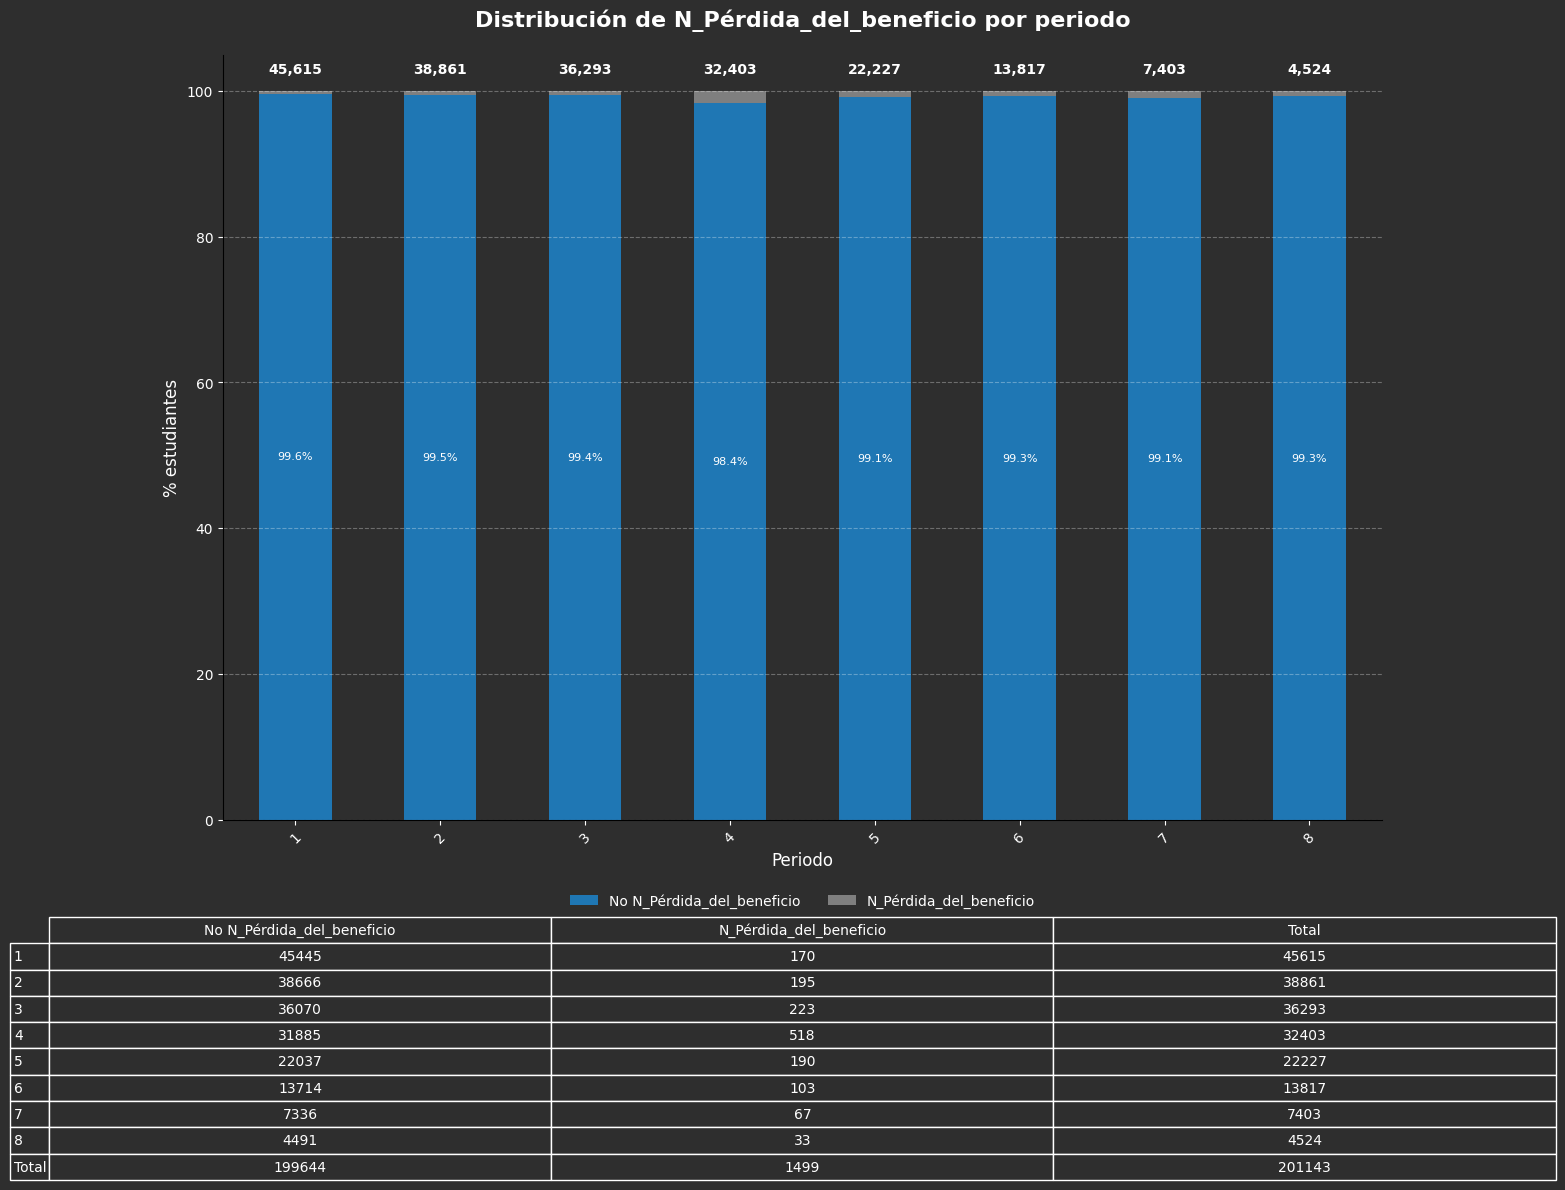

In [11]:
trayectorias_perdida_beneficio, distribucion_perdida_beneficio = (
    detectar_primer_ocurrencia_estado(df, estado="N_Pérdida_del_beneficio")
)

distribucion_historica_perdida_beneficio = plot_evolucion_estado(
    trayectorias_perdida_beneficio,
    "N_Pérdida_del_beneficio",
    output_file=(
        f"output/perdida_beneficio_empirica_panel{version_panel}_{fecha_hoy}"
    )
)

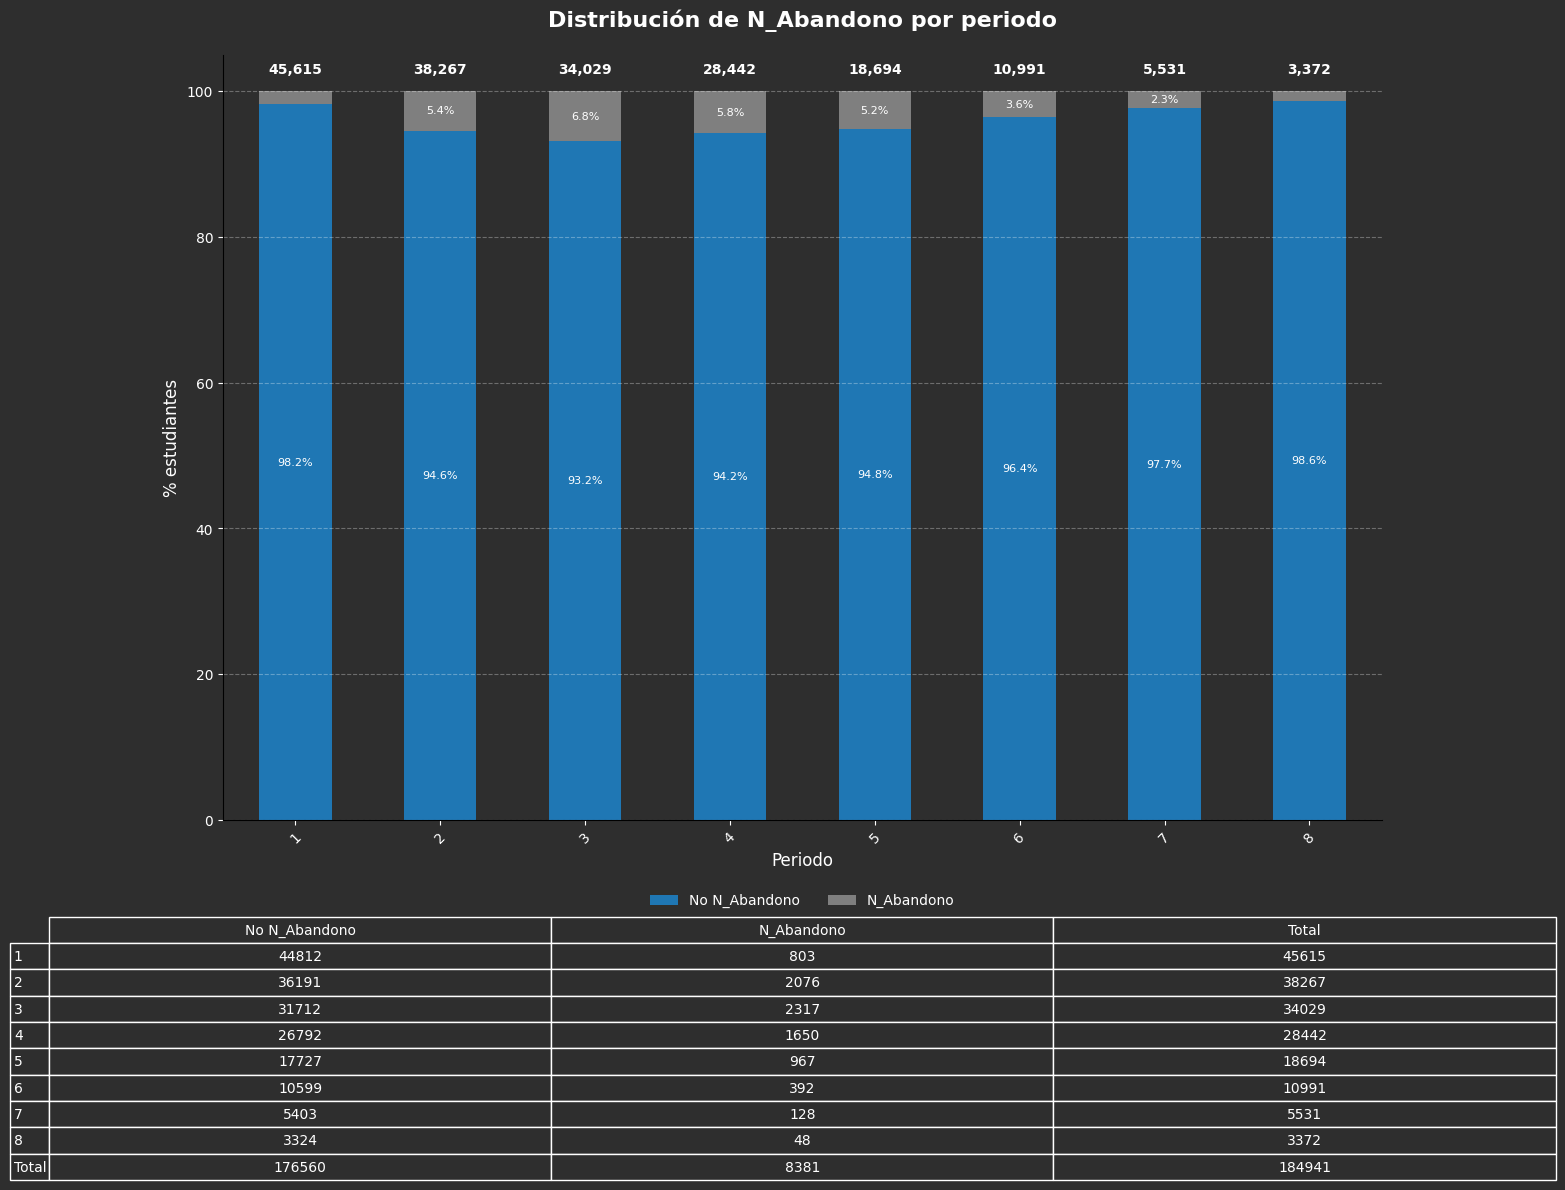

In [12]:
trayectorias_abandonos, distribucion_abandono = (
    detectar_primer_ocurrencia_estado(df, estado="N_Abandono")
)

distribucion_historica_abandono = plot_evolucion_estado(
    trayectorias_abandonos,
    "N_Abandono",
    output_file = f"output/abandono_empirica_panel{version_panel}_{fecha_hoy}"
)

In [13]:
def plot_grilla_estados_convocatorias(
    df: pd.DataFrame,
    super_title: str,
    estado: str = "N_Abandono",
    cols: int = 3,
    figsize: Tuple[int, int] = (18, 6),
    orden_desc: bool = True,
    mostrar_tabla: bool = False
) -> plt.Figure:
    """
    Genera una grilla de subplots con la evolución del estado por convocatoria.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame con columnas 'CONVOCATORIA', 'periodo_orden' y el estado.
    super_title : str
        Título general de la figura.
    estado : str, optional
        Columna binaria a analizar (por defecto 'N_Abandono').
    cols : int, optional
        Número de columnas en la grilla (por defecto 3).
    figsize : tuple, optional
        Tamaño base de cada fila de la figura (por defecto (18, 6)).
    orden_desc : bool, optional
        Si True, ordena las convocatorias en orden descendente.
    mostrar_tabla : bool, optional
        Si True, muestra la tabla debajo de cada gráfico (por defecto False).

    Returns
    -------
    matplotlib.figure.Figure
        Figura completa con todas las subgráficas.
    """

    import math
    import matplotlib.pyplot as plt

    # --- Ordenar convocatorias ---
    convocatorias = sorted(df.CONVOCATORIA.unique(), reverse=orden_desc)
    n = len(convocatorias)
    rows = math.ceil(n / cols)

    # --- Crear figura y ejes ---
    fig, axes = plt.subplots(rows, cols, figsize=(figsize[0], figsize[1] * rows))
    axes = axes.flatten()

    # --- Generar subgráficos ---
    for ax, nombre in zip(axes, convocatorias):
        df_f = df.query(f"CONVOCATORIA == '{nombre}'")
        plot_evolucion_estado(
            df_f,
            estado=estado,
            titulo=f"{nombre}",
            mostrar_tabla=mostrar_tabla,
            ax=ax
        )

    # --- Ocultar ejes vacíos ---
    for ax in axes[n:]:
        ax.axis("off")

    # --- Supertítulo general ---
    fig.suptitle(
        super_title,
        fontsize=20,
        fontweight="bold",
        color="white",
        y=1.02
    )

    fig.tight_layout()
    plt.show()
    return fig



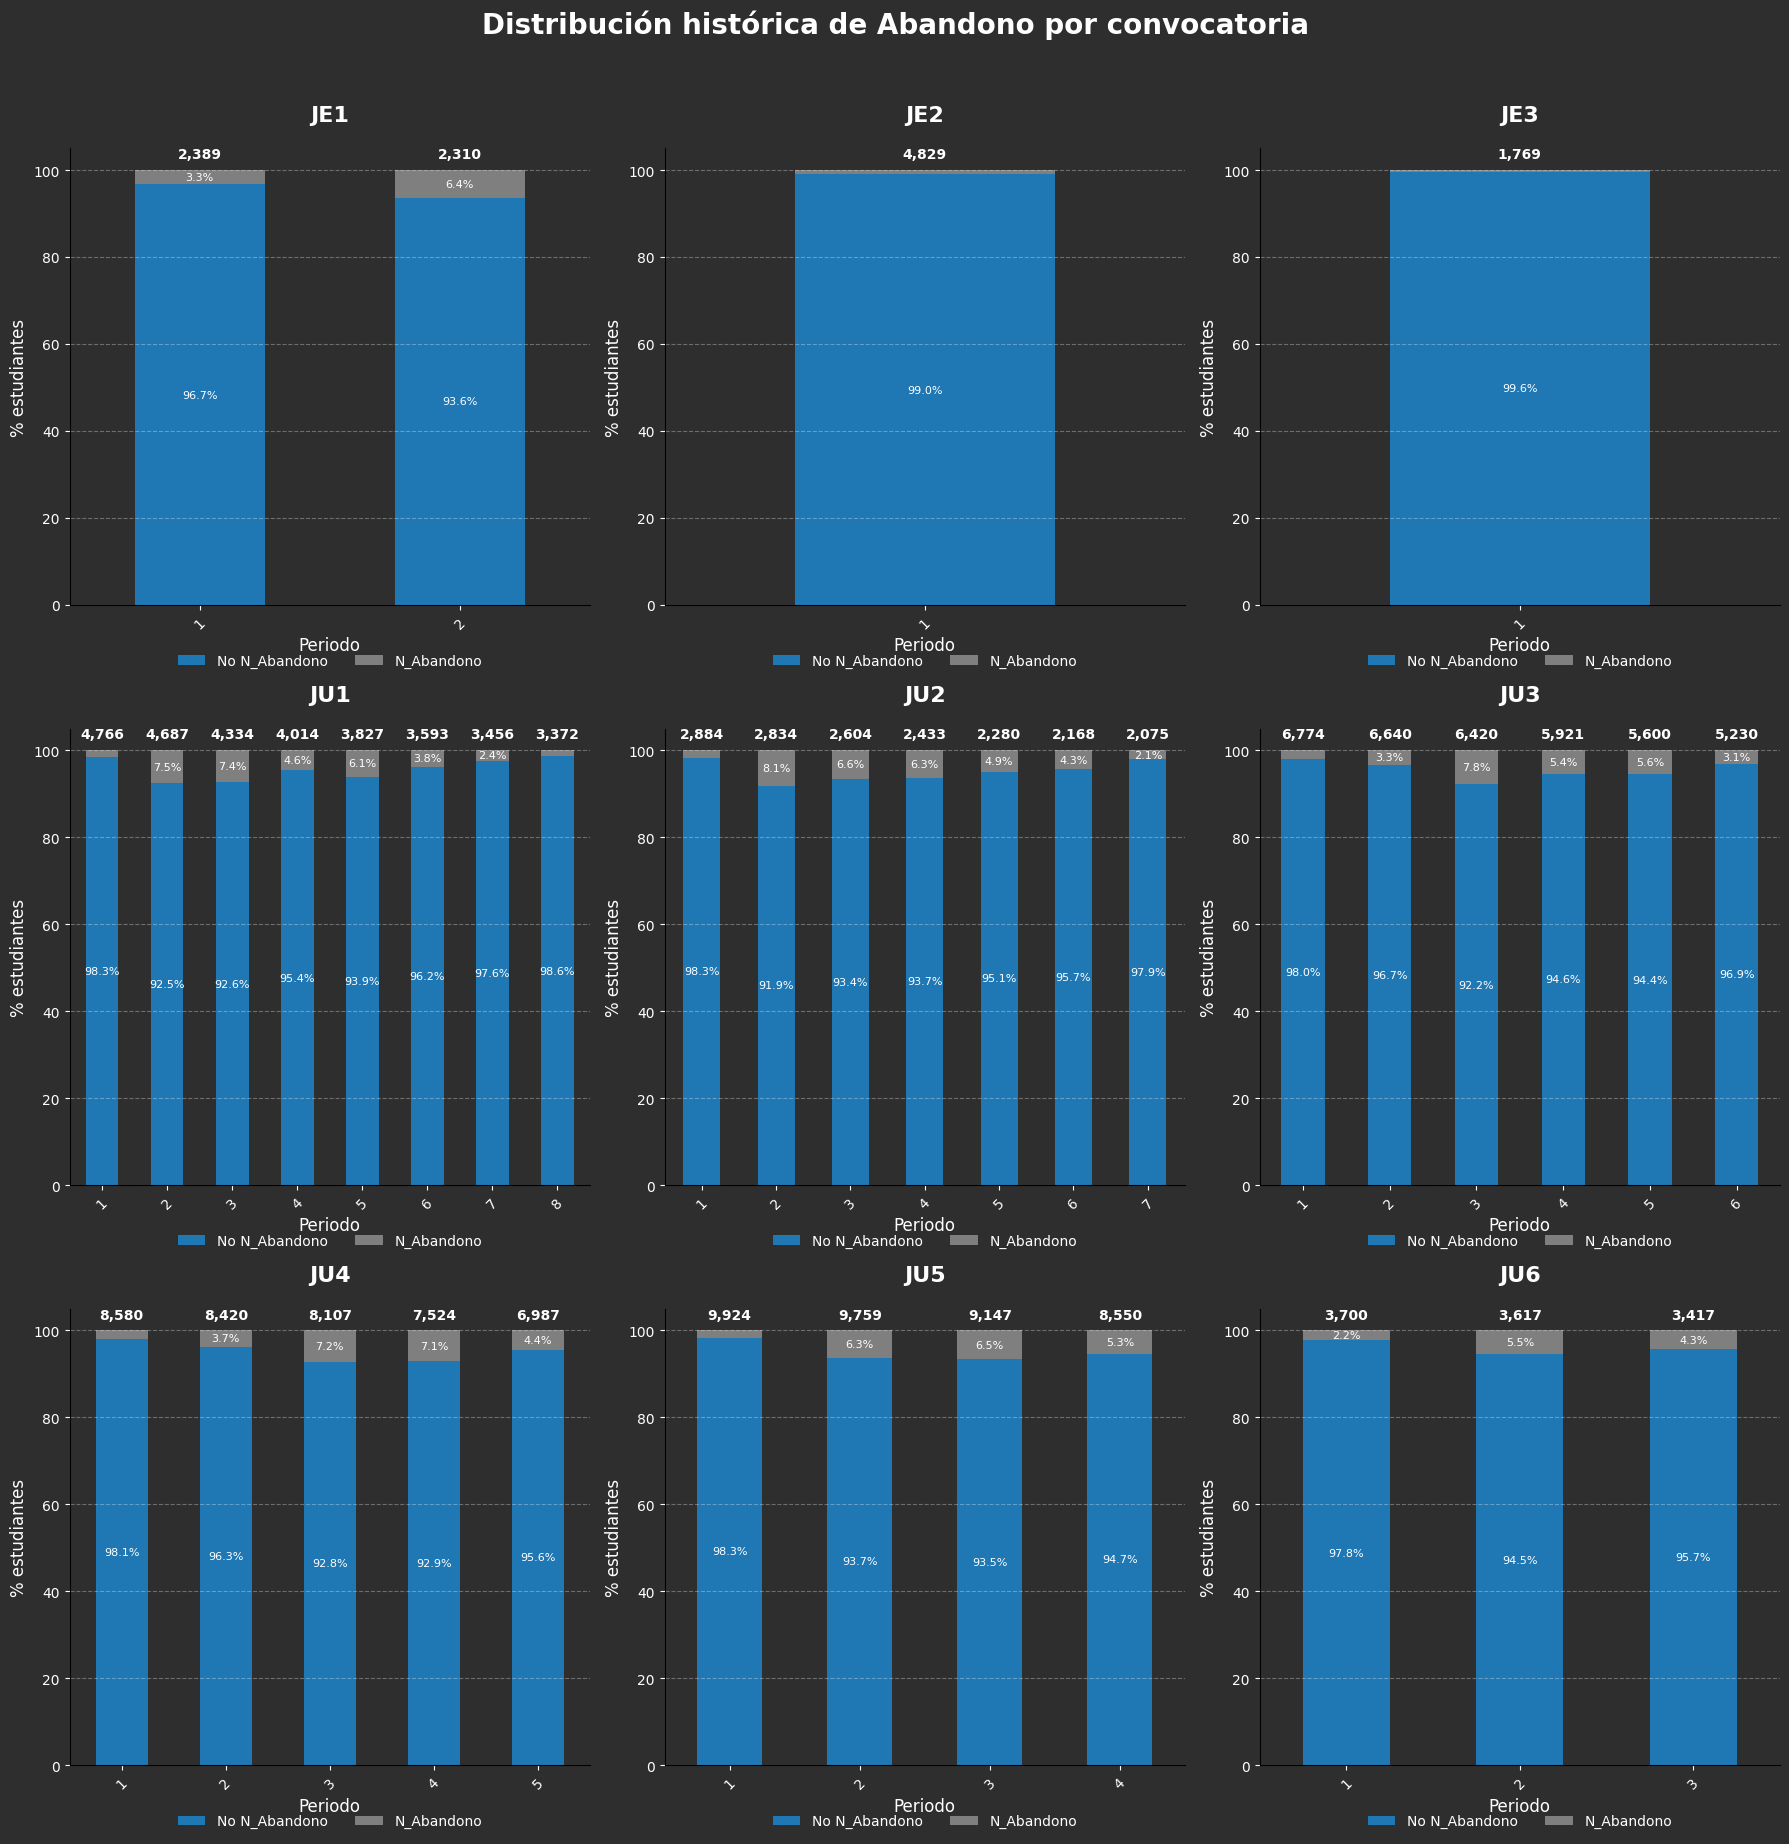

In [14]:
grilla = plot_grilla_estados_convocatorias(
    trayectorias_abandonos,
    estado = "N_Abandono",
    orden_desc = False,
    super_title="Distribución histórica de Abandono por convocatoria"
)

grilla.savefig(f"output/distribucion_histórica_abandono_xconvocatoria_panel{version_panel}_{fecha_hoy}.png")

In [15]:
# Paleta sobria con Graduado en verde BCG
state_colors = {
    "Matriculado": "#0072B2",             # Azul llamativo
    "Aplazado": "#c49c48",                # Beige dorado
    "Abandono": "#8b0000",                # Rojo vino
    "Graduado": "#0A6F37",                # Verde BCG
    "Pérdida del Beneficio": "#6b5b95",   # Púrpura sobrio
    "Sin bolsa de creditos": "#000000"    # Gris acero
}

def plot_estados_con_tabla_acumulados(
    df: pd.DataFrame,
    desde_periodo: int = 20211,
    hasta_periodo: int = 20251,
    estados_acumulativos: List[str] = ["Graduado", "Abandono", "Sin bolsa de creditos", "Pérdida del Beneficio"],
    titulo: Optional[str] = None,
    figsize: Tuple[int,int] = (16, 12),
    umbral: int = 2
):
    """
    Genera un gráfico de evolución histórica de los distintos estados académicos de estudiantes
    a lo largo de varios periodos, junto con una tabla inferior que muestra los valores acumulados
    de ciertos estados seleccionados (por ejemplo, "Graduado" o "Abandono").

    El propósito de esta función es visualizar simultáneamente la distribución general de los estados
    por periodo y el crecimiento acumulativo de los estados absorbentes.
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame con los registros de estudiantes. Debe contener al menos las columnas:
        - `"periodo_key"`: periodo o cohorte (por ejemplo `20211`, `20212`, etc.)
        - `"estado"`: estado categórico del estudiante (por ejemplo `"Matriculado"`, `"Abandono"`, etc.)
    desde_periodo : int, optional
        Periodo inicial a considerar en el filtro. Por defecto `20211`.
    hasta_periodo : int, optional
        Periodo final a considerar en el filtro. Por defecto `20252`.
    estados_acumulativos : list of str, optional
        Lista de estados cuyos valores deben representarse de manera acumulativa a lo largo del tiempo.
        Por defecto `["Graduado", "Abandono", "Sin bolsa de creditos", "Pérdida del Beneficio"]`.
    titulo : str, optional
        Título principal del gráfico. Si no se proporciona, se genera automáticamente indicando
        el rango de periodos analizados.
    figsize : tuple of int, optional
        Tamaño de la figura en pulgadas (ancho, alto). Por defecto `(16, 12)`.
    umbral : int, optional
        Valor mínimo (en número de estudiantes) para mostrar etiquetas dentro de las barras.
        Valores menores se omiten. Por defecto `2`.

    Returns
    -------
    matplotlib.figure.Figure
        Objeto `Figure` de Matplotlib que contiene la visualización completa (gráfico + tabla).

    Notes
    -----
    - Los estados definidos en `state_colors` se colorean automáticamente según una paleta sobria
      (azul, verde, vino, púrpura, gris, etc.).
    - Los valores acumulativos se calculan mediante una suma acumulada (`cumsum`) por columna.
    - La tabla inferior muestra exclusivamente los estados incluidos en `estados_acumulativos`.
    - Los valores en el gráfico se muestran en formato compacto (“1.2k” para miles).

    Example
    -------
    >>> fig = plot_estados_con_tabla_acumulados(
    ...     df=datos_estudiantes,
    ...     desde_periodo=20211,
    ...     hasta_periodo=20251,
    ...     titulo="Evolución histórica de los estados académicos"
    ... )
    >>> plt.show()
    """

    # --- Filtrar convocatorias ---
    df_filt = df.query(f"periodo_key>={desde_periodo} & periodo_key<={hasta_periodo}").copy()

    # --- Conteos por estado y periodo ---
    counts = df_filt.groupby(["periodo_key", "estado"]).size().unstack(fill_value=0)

    # --- Estados que deben acumularse ---
    acumulativos = estados_acumulativos

    # 🔧 Ajuste: conservar solo los estados presentes en counts
    acumulativos = [c for c in acumulativos if c in counts.columns]

    # Aplicar acumulado
    for col in acumulativos:
        counts[col] = counts[col].cumsum()

    # --- Solo tabla de acumulativos ---
    table_data = counts[acumulativos].copy()

    # --- Crear figura ---
    fig, (ax_plot, ax_table) = plt.subplots(
        2, 1, figsize=figsize,
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # 🎨 Fondos
    fig.patch.set_facecolor("#f7f7f7")   # gris claro elegante
    ax_plot.set_facecolor("white")       # área de gráfico clara
    ax_table.set_facecolor("#f7f7f7")

    # --- Gráfico de barras ---
    counts.plot(
        kind="bar",
        ax=ax_plot,
        width=0.7,
        color=[state_colors.get(c, "#999999") for c in counts.columns]
    )

    # 🎯 Etiquetas en formato K
    def fmt_k(x):
        if x >= 1000:
            return f"{x/1000:.1f}k"
        return str(int(x))

    for container in ax_plot.containers:
        ax_plot.bar_label(
            container,
            labels=[fmt_k(v.get_height()) if v.get_height() > 0 else "" for v in container],
            label_type="edge",
            fontsize=8,
            color="black"
        )

    # --- Estilo del gráfico ---
    ax_plot.set_title(
        titulo or f"Evolución histórica de estados a partir de {desde_periodo}",
        fontsize=16, fontweight="bold", color="black"
    )
    ax_plot.set_xlabel("Periodo", fontsize=12, color="black")
    ax_plot.set_ylabel("Número de estudiantes", fontsize=12, color="black")
    ax_plot.tick_params(axis="x", colors="black", rotation=45)
    ax_plot.tick_params(axis="y", colors="black")
    ax_plot.grid(axis="y", linestyle="--", alpha=0.3, color="gray")

    # Leyenda
    ax_plot.legend(
        title="Estado",
        bbox_to_anchor=(0.5, 1.05),
        loc="lower center",
        ncol=3,
        frameon=False
    )

    # --- Tabla ---
    ax_table.axis("off")
    table = ax_table.table(
        cellText=table_data.values,
        colLabels=table_data.columns,
        rowLabels=table_data.index,
        cellLoc="center",
        loc="center"
    )
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.0, 1.3)
    
    # 👉 Aquí añades el ajuste automático
    table.auto_set_column_width(col=list(range(len(table_data.columns))))
    
    # Colorear tabla
    for key, cell in table.get_celld().items():
        cell.set_edgecolor("black")
        cell.set_facecolor("#f7f7f7")
        cell.set_text_props(color="black")



    # Ajuste más limpio (sin tight_layout warning)
    plt.subplots_adjust(hspace=0.4)
    return fig

In [16]:
def limpiar_trayectorias_estado_absorbente(
    df: pd.DataFrame,
    estados_absorbentes: List[str]
) -> pd.DataFrame:
    """
    Recorta las trayectorias académicas o de seguimiento de cada individuo después de la primera
    aparición en un estado absorbente (por ejemplo, "Graduado", "Abandono", etc.).

    Este proceso es útil para analizar trayectorias longitudinales en las que ciertos estados
    representan condiciones terminales o finales, evitando contar periodos posteriores
    innecesarios o inconsistentes.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame que contiene la información de las trayectorias individuales. Debe incluir
        al menos las siguientes columnas:
        - `"DOCUMENTO"`: identificador único de cada individuo.
        - `"periodo_key"`: variable temporal ordenable (por ejemplo, periodo académico).
        - `"estado"`: estado o condición del individuo en cada periodo.
    estados_absorbentes : list of str
        Lista de nombres de estados considerados absorbentes. Una vez que un individuo
        alcanza cualquiera de estos estados, se descartan los registros posteriores.

    Returns
    -------
    pandas.DataFrame
        DataFrame filtrado que conserva, para cada individuo, únicamente los registros
        hasta (e incluyendo) su primer estado absorbente.

    Notes
    -----
    - El DataFrame se ordena internamente por `DOCUMENTO` y `periodo_key` para garantizar
      la secuencia temporal correcta.
    - Si un individuo nunca alcanza un estado absorbente, se conserva su trayectoria completa.
    - Este tipo de recorte es común en análisis de supervivencia o estudios de deserción
      y graduación.

    Example
    -------
    >>> estados_finales = ["Graduado", "Abandono"]
    >>> df_limpio = limpiar_trayectorias_estado_absorbente(df_estudiantes, estados_finales)
    >>> df_limpio.head()

    """

    # Asegurar orden cronológico
    df = df.sort_values(["DOCUMENTO", "periodo_key"]).copy()

    # Detectar primer periodo absorbente por individuo
    primer_absorbente = (
        df[df["estado"].isin(estados_absorbentes)]
        .groupby("DOCUMENTO")["periodo_key"]
        .min()
    )

    # Recortar trayectorias hasta el primer estado absorbente
    df_filtrado = []
    for doc, grupo in df.groupby("DOCUMENTO"):
        if doc in primer_absorbente:
            cutoff = primer_absorbente.loc[doc]
            grupo = grupo[grupo["periodo_key"] <= cutoff]
        df_filtrado.append(grupo)

    df_filtrado = pd.concat(df_filtrado, axis=0)
    return df_filtrado
    

**Definición de DataFrame - Trayectorias recortadas**

Nombre: df_limpio

In [17]:
#listado con los nombres de los estados absorbentes
estados_absorbentes = listado_estados.query("es_absorbente == 1").Estados

df_limpio = limpiar_trayectorias_estado_absorbente(df, estados_absorbentes)

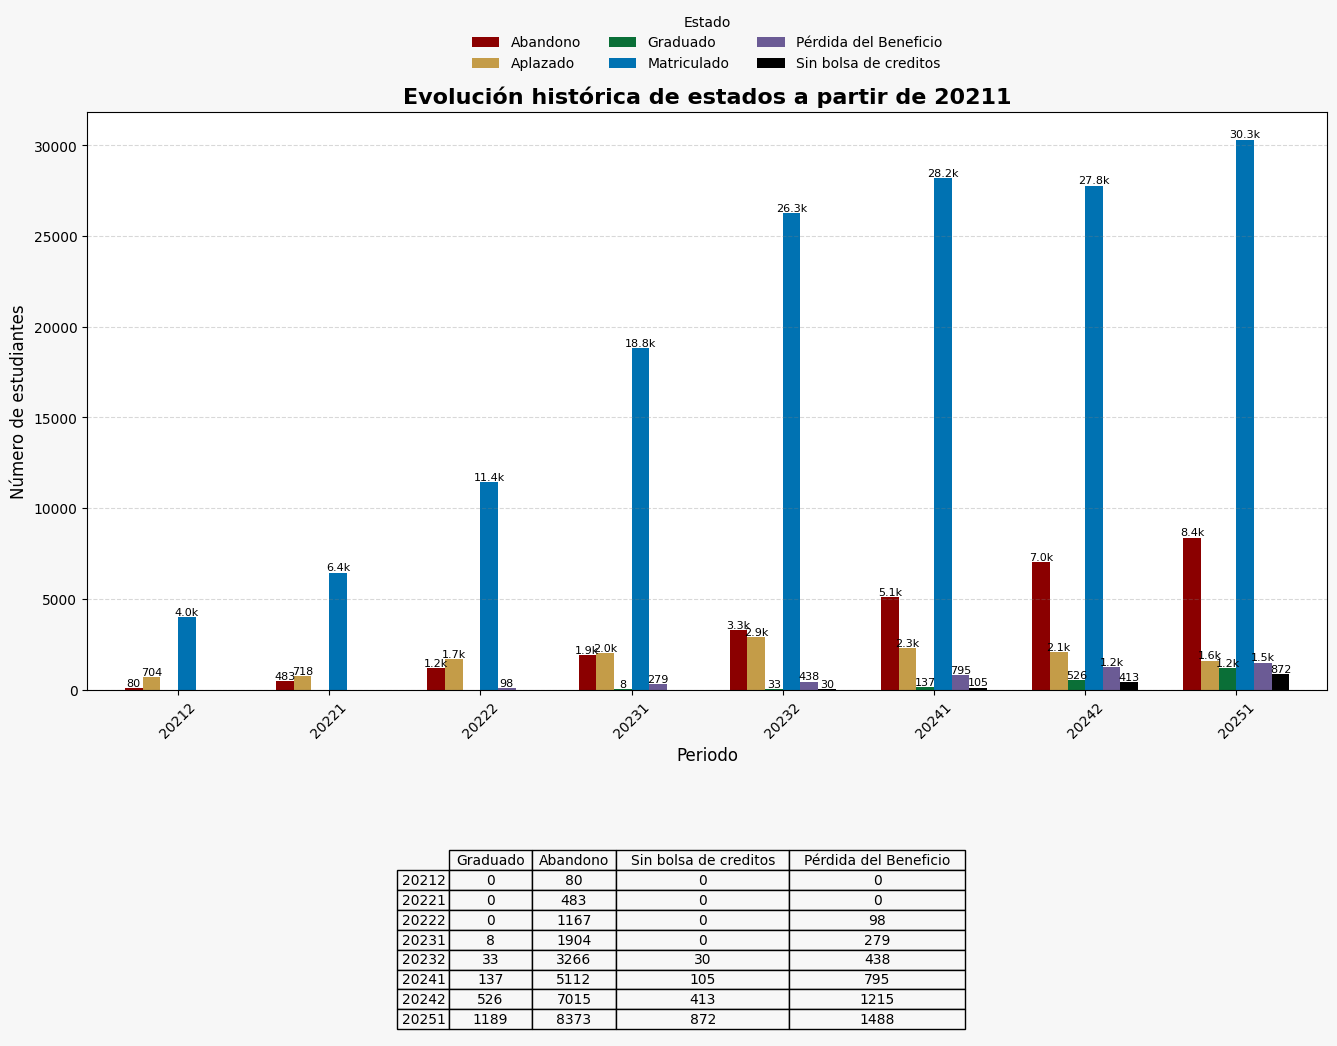

In [18]:
# Ahora pasar df_limpio directamente a la  función:
fig = plot_estados_con_tabla_acumulados(df_limpio, desde_periodo=20211, hasta_periodo=20251)
fig.savefig(f"output/evolucion_empirica_estados_panel{version_panel}_{fecha_hoy}.png")

-------

### **Sección para graficar el panorama completo de las proyecciones**

**Pasos:**

1. Cargar los dataframes de las proyecciones y concatenarlos en un solo dataframe llamado df_trayectorias. 
2. Desduplicar las observaciones del 20251 (periodo de corte) con el historico de trayectorias (a.k.a df_limpio).
3. Graficar

**Paso 1:  Cargar los dataframes de las proyecciones y concatenarlos**

**Nota:**
- Se tienen 2 df de proyecciones: 1. para todas las convocatorias y 2. para las convocatorias de JE1 Y JE2. Se tiene este último por los supuestos de aprobación de créditos que se hicieron para las convocatorias más recientes. 

In [19]:
trayectorias_file = "trayectorias_JE_supuesto10pctaprobacion_panelV12_20251028.pkl"
supuesto_trayectorias = "10pctaprobacionJE"

df_trayectorias = pd.read_pickle(f"trayectorias/{trayectorias_file}")
df_trayectorias = df_trayectorias.rename(columns={"CEDULA": "DOCUMENTO"})

In [20]:
#trayectorias_file = "TRAYECTORIAS_JU1-JU6_PANELV12_ALEATORIOS_V00.pkl"
#supuesto_trayectorias = "estados_aleatorios"

#df_trayectorias = pd.read_pickle(f"{trayectorias_file}")
#df_trayectorias = df_trayectorias.rename(columns={"CEDULA": "DOCUMENTO"})

In [21]:
df_trayectorias.CONVOCATORIA.unique()

array(['JE1', 'JE2'], dtype=object)

**Quitar por JE3 porque no se le aplico el supuesto del 10% de aprobación**

In [22]:
df_trayectorias = df_trayectorias.loc[~df_trayectorias['CONVOCATORIA'].isin(["JE3"]),:]

**Paso 2: Desduplicar las observaciones del ultimo periodo observado (del histórico) con el punto de partida de la trayectoria pronosticada.**

- En este punto es importante que la version del panel historico haya sido la misma con la cual se realizó la proyección.

In [37]:
# 1️⃣ Identificar el último periodo observado por cada individuo en df_limpio.
# Acá están por ejemplo las personas que abandonaron en el programa en 2022-2 
ultimo_periodo_obs = (
    df_limpio.groupby("DOCUMENTO")["periodo_key"]
    .max()
    .reset_index(name="ultimo_periodo_key")
)

# 2️⃣ Eliminar de df_trayectorias las filas que coinciden con ese último periodo observado
# Cuáles de las personas con proyección aparecen en el dataframe histórico (df_limpio)
df_trayectorias_filtrado = df_trayectorias.merge(
    ultimo_periodo_obs,
    on="DOCUMENTO",
    how="left"
)

In [42]:
df_trayectorias_filtrado.shape

(14528, 45)

In [44]:
df_trayectorias_completas.columns

Index(['DOCUMENTO', 'NIVEL_SISBEN_4', 'SEXO', 'GRUPO_ETNICO', 'HIJOS',
       'SABER11_PUNTAJE_GLOBAL', 'SNIES_IES', 'IES_NOMBRE', 'SNIES_PROGRAMA',
       'PROGRAMA', 'TIPO_IES', 'FUENTE_TERRITORIAL', 'CONVENIO_FDL',
       'FUENTE_FINANCIACION_ACCESO', 'FUENTE_FINANCIACION_APOYOS',
       'NIVEL_FORMACION', 'CINE_CAMPO_AMPLIO', 'MODALIDAD', 'CONVOCATORIA',
       'PERIODOS_BD_SNIES', 'CREDITOS_PROGRAMA', 'estado_inicial',
       'periodo_key', 'estado', 'pct_perd_acum', 'pct_aprob_acum',
       'N_Aplazado', 'N_Matriculado', 'N_Abandono', 'N_Sin_bolsa_de_creditos',
       'N_Pérdida_del_beneficio', 'N_Matriculas_adicionales', 'N_Graduado',
       'estado_next', 'periodo_orden', 'N_Periodos_adicionales', 'semestre',
       'prop_matriculado', 'N_Aplazado_voluntarios_disponibles',
       'creditos_x_semestre', 'pct_aprob_acum_teorica', 'razon_estado',
       'prob_Abandono', 'prob_Aplazado', 'prob_Matriculado'],
      dtype='object')

In [45]:
# 1️⃣ Identificar el último periodo observado por cada individuo en df_limpio.
# Acá están por ejemplo las personas que abandonaron en el programa en 2022-2 
ultimo_periodo_obs = (
    df_limpio.groupby("DOCUMENTO")["periodo_key"]
    .max()
    .reset_index(name="ultimo_periodo_key")
)

# 2️⃣ Eliminar de df_trayectorias las filas que coinciden con ese último periodo observado
# Cuáles de las personas con proyección aparecen en el dataframe histórico (df_limpio)
df_trayectorias_filtrado = df_trayectorias.merge(
    ultimo_periodo_obs,
    on="DOCUMENTO",
    how="left"
)

df_trayectorias_filtrado = df_trayectorias_filtrado[
    df_trayectorias_filtrado["periodo_key"] != df_trayectorias_filtrado["ultimo_periodo_key"]
].drop(columns="ultimo_periodo_key")

# 3️⃣ Concatenar observaciones + trayectorias sin duplicar el punto de partida
df_trayectorias_completas = (
    pd.concat([df_limpio, df_trayectorias_filtrado], ignore_index=True)
      .sort_values(by=["DOCUMENTO", "periodo_key"], ascending = [False, True])
      .reset_index(drop=True)
)

# 4️⃣ (Opcional pero recomendable): asegurar unicidad
#df_trayectorias_completas = df_trayectorias_completas.drop_duplicates(
#    subset=["DOCUMENTO", "periodo_key"],
#    keep="first"
#)

# 5️⃣ Homogeneizar nombres de estado
df_trayectorias_completas["estado"] = df_trayectorias_completas["estado"].replace({
    "Pérdida del Beneficio": "Pérdida_del_beneficio",
    "Sin bolsa de creditos": "Sin_bolsa_de_creditos"
})


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Optional, Tuple

# Paleta de colores
state_colors = {
    "Matriculado": "#0072B2",             # Azul llamativo
    "Aplazado": "#c49c48",                # Beige dorado
    "Abandono": "#8b0000",                # Rojo vino
    "Graduado": "#0A6F37",                # Verde BCG
    "Pérdida_del_beneficio": "#c49c48",   # Púrpura sobrio
    "Sin_bolsa_de_creditos": "#7d7d7d",   # Gris acero
    "No aplica": "#999999"                # Gris genérico
}


def plot_estados_con_tabla_acumulados(
    df_trayectorias: pd.DataFrame,
    desde_periodo: int = 20252,
    hasta_periodo: int = 20401,
    titulo: Optional[str] = None,
    figsize: Tuple[int, int] = (16, 12),
    umbral: int = 2,
    estados: Optional[List[str]] = None
) -> plt.Figure:
    
    """
    Genera un gráfico combinado que muestra la evolución acumulada de los estados académicos
    de los estudiantes entre un rango de periodos, acompañado de una tabla inferior con los
    valores acumulativos.

    El gráfico principal combina barras apiladas (una por estado) y una línea de tendencia 
    para el estado "Graduado". Solo los estados definidos como absorbentes se acumulan en el tiempo,
    mientras que los demás se muestran sin acumulación. 

    Parameters
    ----------
    df_trayectorias : pandas.DataFrame
        DataFrame con las trayectorias de los estudiantes. Debe incluir:
        - `"periodo_key"`: periodo o cohorte numérica (por ejemplo, 20252, 20301, etc.).
        - `"estado"`: estado académico de cada registro (ej. "Matriculado", "Abandono", etc.).
    desde_periodo : int, optional
        Periodo inicial a graficar. Por defecto `20252`.
    hasta_periodo : int, optional
        Periodo final a graficar. Por defecto `20401`.
    titulo : str, optional
        Título del gráfico. Si no se especifica, se usa un título genérico.
    figsize : tuple of int, optional
        Tamaño de la figura en pulgadas `(ancho, alto)`. Por defecto `(16, 12)`.
    umbral : int, optional
        Valor mínimo para mostrar etiquetas de conteo sobre las barras. Por defecto `2`.
    estados : list of str, optional
        Lista de estados específicos a graficar. Si se omite, se muestran solo los estados
        absorbentes definidos: `["Graduado", "Pérdida_del_beneficio", "Sin_bolsa_de_creditos", "Abandono"]`.

    Returns
    -------
    matplotlib.figure.Figure
        Figura de Matplotlib que contiene el gráfico de barras y la tabla de acumulados.

    Notes
    -----
    - Los estados absorbentes se acumulan a lo largo del tiempo (`cumsum()`).
    - Los valores se muestran en formato compacto ("k" para miles).
    - Los colores dependen del diccionario global `state_colors`.

    Example
    -------
    >>> fig = plot_estados_con_tabla_acumulados(
    ...     df_trayectorias=df_panel,
    ...     desde_periodo=20252,
    ...     hasta_periodo=20401,
    ...     titulo="Evolución de estados acumulados 2025–2040",
    ...     estados=["Graduado", "Abandono"]
    ... )
    >>> plt.show()
    """
    # --- Filtrar por periodo ---
    df_filt = df_trayectorias.query(
        f"periodo_key >= {desde_periodo} & periodo_key <= {hasta_periodo}"
    ).copy()

    # --- Conteos por estado y periodo ---
    counts = df_filt.groupby(["periodo_key", "estado"]).size().unstack(fill_value=0)

    # --- Estados absorbentes ---
    absorbentes = ["Graduado", "Pérdida_del_beneficio", "Sin_bolsa_de_creditos", "Abandono"]

    # --- Determinar estados a graficar ---
    if estados is not None:
        estados_plot = [e for e in estados if e in counts.columns]
    else:
        estados_plot = [e for e in absorbentes if e in counts.columns]

    # --- Acumular solo absorbentes ---
    for col in absorbentes:
        if col in counts.columns:
            counts[col] = counts[col].cumsum()

    counts_plot = counts[estados_plot].copy()

    # --- Crear figura dinámicamente ---
    if len(counts_plot) > 10:
        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(
            2, 3,
            height_ratios=[3, 1],
            width_ratios=[1, 0.05, 1],   # 👈 separador más estrecho
            wspace=0.02, hspace=0.25
        )
        ax_plot = fig.add_subplot(gs[0, :])
        ax_table1 = fig.add_subplot(gs[1, 0])
        ax_table2 = fig.add_subplot(gs[1, 2])
        usar_dos_tablas = True
    else:
        fig, (ax_plot, ax_table1) = plt.subplots(
            2, 1, figsize=figsize,
            gridspec_kw={"height_ratios": [3, 1]}
        )
        usar_dos_tablas = False

    # --- Estilos base ---
    fig.patch.set_facecolor("#f7f7f7")
    ax_plot.set_facecolor("white")
    ax_table1.set_facecolor("#f7f7f7")
    if usar_dos_tablas:
        ax_table2.set_facecolor("#f7f7f7")

    # --- Gráfico de barras ---
    counts_plot.plot(
        kind="bar",
        ax=ax_plot,
        width=0.7,
        color=[state_colors.get(c, "#999999") for c in counts_plot.columns]
    )

    # --- Etiquetas con formato K ---
    def fmt_k(x):
        if x >= 1000:
            return f"{x/1000:.1f}k"
        return str(int(x))

    for container in ax_plot.containers:
        ax_plot.bar_label(
            container,
            labels=[fmt_k(v.get_height()) if v.get_height() > umbral else "" for v in container],
            label_type="edge",
            fontsize=8,
            color="black"
        )

    # --- Línea de tendencia visible (Graduado) ---
    if "Graduado" in counts_plot.columns:
        x = np.arange(len(counts_plot))
        y = counts_plot["Graduado"].values
        ax_plot.plot(
            x,
            y,
            color=state_colors.get("Graduado", "#0A6F37"),
            linestyle="--",
            linewidth=2.5,
            marker="o",
            zorder=10,
            label="Tendencia Graduado"
        )
        ax_plot.set_xticks(x)
        ax_plot.set_xticklabels(counts_plot.index, rotation=45)

    # --- Estilo general ---
    ax_plot.set_title(
        titulo or "Evolución de estados acumulados",
        fontsize=16, fontweight="bold", color="black"
    )
    ax_plot.set_xlabel("Periodo", fontsize=12, color="black")
    ax_plot.set_ylabel("Número de estudiantes", fontsize=12, color="black")
    ax_plot.tick_params(axis="x", colors="black")
    ax_plot.tick_params(axis="y", colors="black")
    ax_plot.grid(axis="y", linestyle="--", alpha=0.3, color="gray")

    ax_plot.legend(
        title="Estado",
        bbox_to_anchor=(0.5, 1.05),
        loc="lower center",
        ncol=3,
        frameon=False
    )

    # --- Tablas ---
    if usar_dos_tablas:
        mitad = len(counts_plot) // 2
        tabla_1 = counts_plot.iloc[:mitad, :]
        tabla_2 = counts_plot.iloc[mitad:, :]

        for ax, data in zip([ax_table1, ax_table2], [tabla_1, tabla_2]):
            ax.axis("off")
            table = ax.table(
                cellText=data.values,
                colLabels=data.columns,
                rowLabels=data.index,
                cellLoc="center",
                loc="center"
            )
            table.auto_set_font_size(False)
            table.set_fontsize(10)
            table.scale(0.9, 1.2)
            table.auto_set_column_width(col=list(range(len(counts_plot.columns))))
            for key, cell in table.get_celld().items():
                cell.set_edgecolor("black")
                cell.set_facecolor("#f7f7f7")
                cell.set_text_props(color="black")
    else:
        ax_table1.axis("off")
        table = ax_table1.table(
            cellText=counts_plot.values,
            colLabels=counts_plot.columns,
            rowLabels=counts_plot.index,
            cellLoc="center",
            loc="center"
        )
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.0, 1.3)
        table.auto_set_column_width(col=list(range(len(counts_plot.columns))))
        for key, cell in table.get_celld().items():
            cell.set_edgecolor("black")
            cell.set_facecolor("#f7f7f7")
            cell.set_text_props(color="black")

    plt.subplots_adjust(hspace=0.4)
    return fig


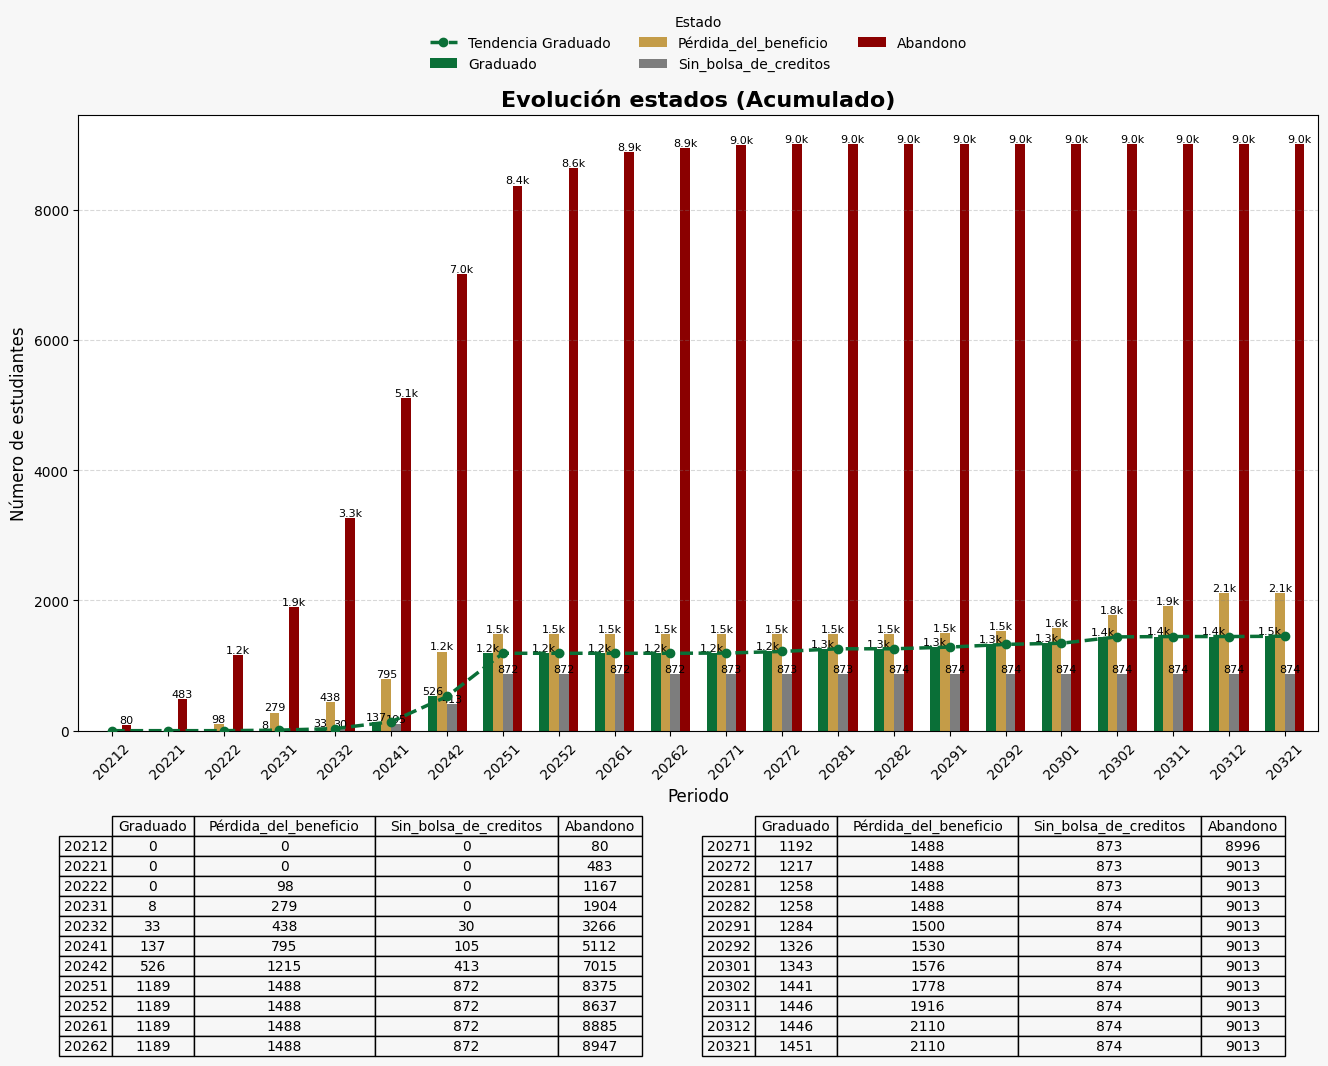

In [47]:
# Generar la figura con tu función
evolucion_estados_acumulados = plot_estados_con_tabla_acumulados(
    df_trayectorias_completas,
    titulo="Evolución estados (Acumulado)",
    desde_periodo= 20212,
    hasta_periodo = 20401
)

evolucion_estados_acumulados.savefig(f"output/evolucion_completa_estados_{supuesto_trayectorias}_JE_{version_panel}_{fecha_hoy}.png")

In [48]:
#from matplotlib.backends.backend_pdf import PdfPages
# Guardarla en un PDF
#with PdfPages(f"evolucion_completa_estados_trayectorias{version_panel}_{supuesto_trayectorias}_{fecha_hoy}.pdf") as pdf:
#    pdf.savefig(evolucion_estados_acumulados)
#    plt.close(evolucion_estados_acumulados)

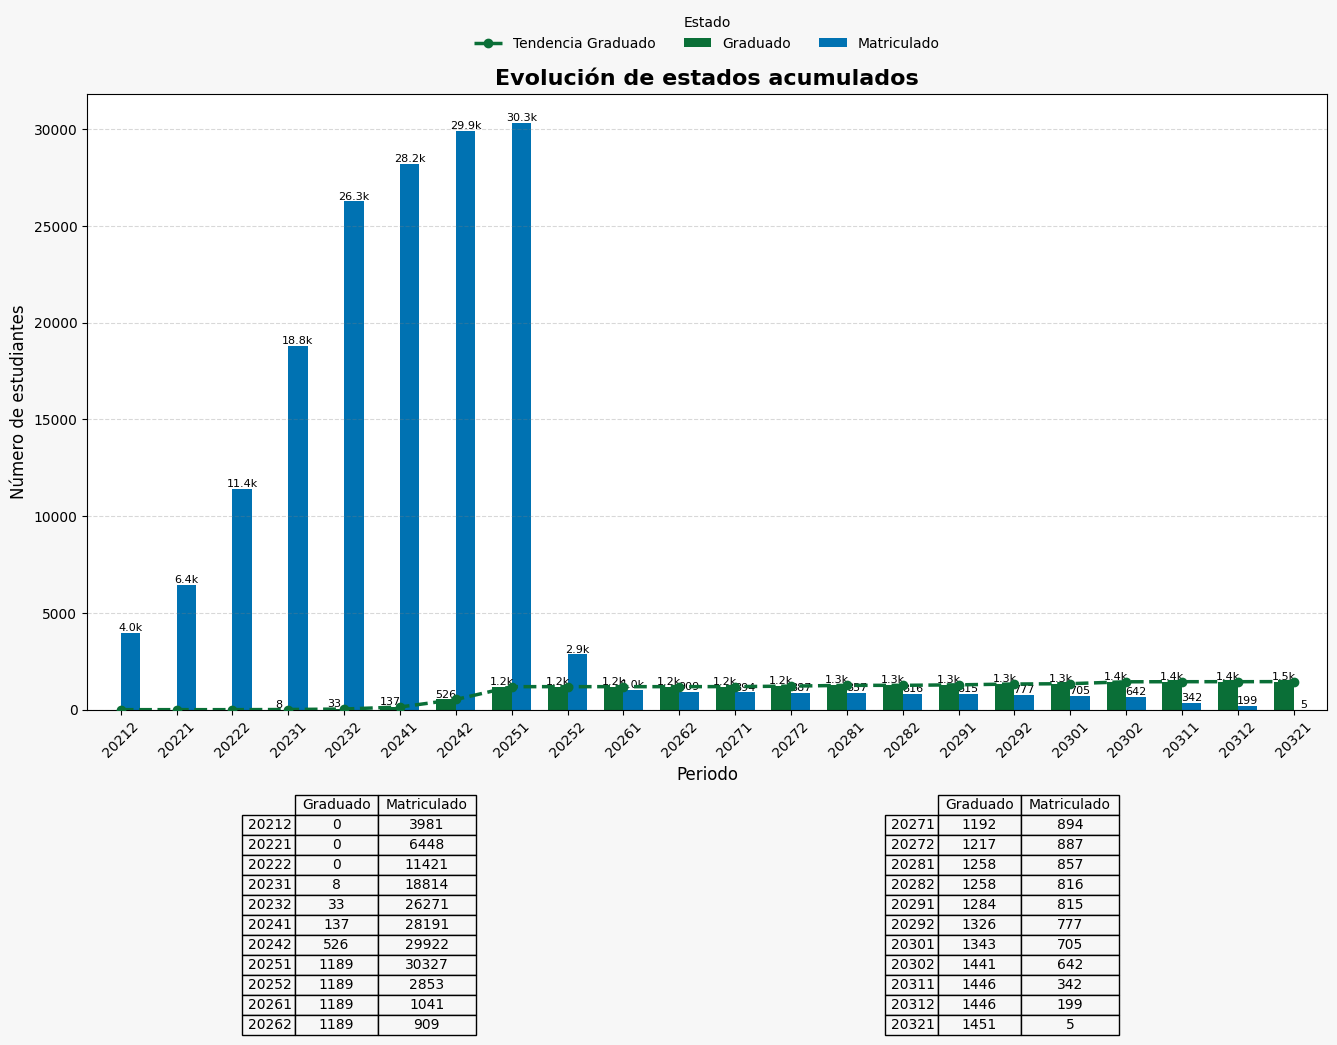

In [49]:
# Graficar solo Graduado y Pérdida del beneficio
evolucion_graduados_matriculados = plot_estados_con_tabla_acumulados(
    df_trayectorias_completas,
    desde_periodo=20211,
    hasta_periodo=20401,
    estados=["Graduado", "Matriculado"]
)
evolucion_graduados_matriculados.savefig(f"output/evolucion_graduados_matriculados_{supuesto_trayectorias}_JE_{version_panel}_{fecha_hoy}.png")
plt.show()

# Guardarla en un PDF
#with PdfPages(f"evolucion_graduados_matriculados_trayectorias{version_panel}_{supuesto_trayectorias}_{fecha_hoy}.pdf") as pdf:
#    pdf.savefig(evolucion_graduados_matriculados)
#    plt.close(evolucion_graduados_matriculados)

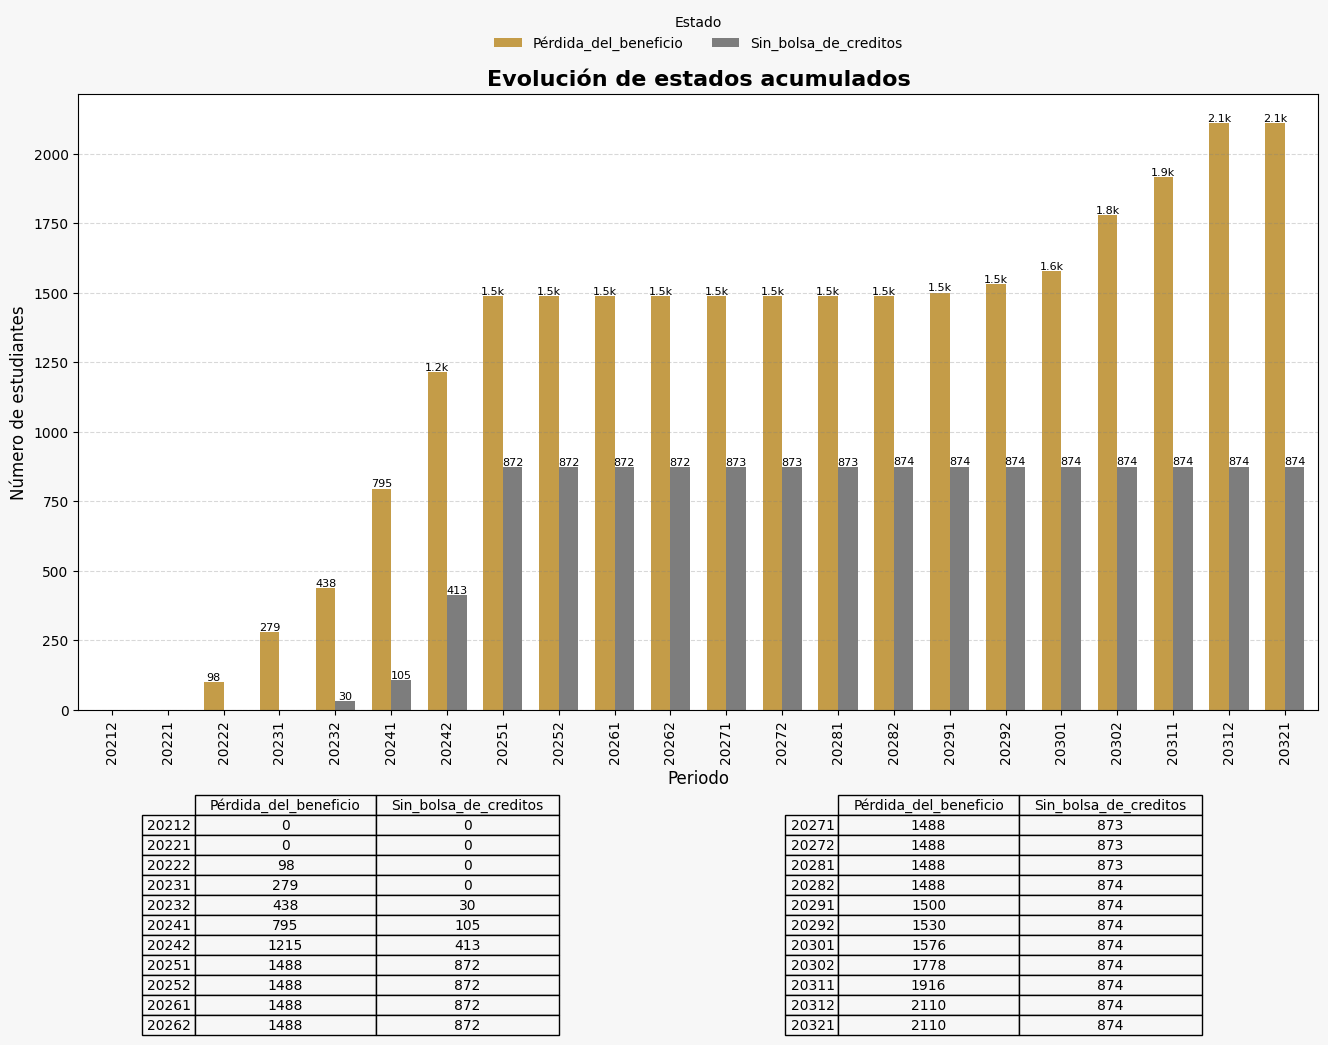

In [50]:
# Graficar solo Graduado y Pérdida del beneficio
evolucion_perdidaBeneficio_sinBolsa = plot_estados_con_tabla_acumulados(
    df_trayectorias_completas,
    desde_periodo=20211,
    hasta_periodo=20401,
    estados=["Pérdida_del_beneficio", "Sin_bolsa_de_creditos"]
)
evolucion_perdidaBeneficio_sinBolsa.savefig(f"output/evolucion_perdidaBeneficio_sinBolsa_{supuesto_trayectorias}_JE_{version_panel}_{fecha_hoy}.png")
plt.show()

# Guardarla en un PDF
#with PdfPages(f"evolucion_perdidaBeneficio_sinBolsa_trayectorias{version_panel}_{supuesto_trayectorias}_{fecha_hoy}.pdf") as pdf:
#    pdf.savefig(evolucion_perdidaBeneficio_sinBolsa)
#    plt.close(evolucion_perdidaBeneficio_sinBolsa)
